Step 0: class score = -0.1178
Step 20: class score = 103.2179
Step 40: class score = 201.8450
Step 60: class score = 259.2603
Step 80: class score = 298.7726
Step 100: class score = 327.7661
Step 120: class score = 349.4098
Step 140: class score = 368.4002
Step 160: class score = 378.9282
Step 180: class score = 392.7849
Step 200: class score = 402.9059
Step 220: class score = 411.3223
Step 240: class score = 420.1200
Step 260: class score = 428.0036
Step 280: class score = 431.3558


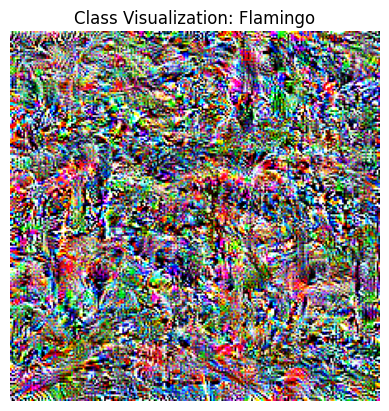

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)
model.eval()

# Target class (Flamingo)
target_class = 130

# Random noise image (input)
input_img = torch.randn(1, 3, 224, 224, requires_grad=True)

# Normalization transform (ImageNet standard)
preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

# Optimizer
optimizer = torch.optim.Adam([input_img], lr=0.05)

# Optimization loop
for step in range(300):
    optimizer.zero_grad()

    # Apply normalization
    norm_img = preprocess(input_img.squeeze(0)).unsqueeze(0)

    # Forward pass
    output = model(norm_img)

    # Loss: maximize score for target class
    loss = -output[0, target_class]

    # Backward pass
    loss.backward()
    optimizer.step()

    # Keep image values in [0, 1] range
    input_img.data = torch.clamp(input_img.data, 0, 1)

    if step % 20 == 0:
        print(f"Step {step}: class score = {-loss.item():.4f}")

# Convert tensor to image format
generated_img = input_img.detach().squeeze().permute(1, 2, 0).numpy()

# Display image
plt.imshow(generated_img)
plt.title("Class Visualization: Flamingo")
plt.axis("off")
plt.show()


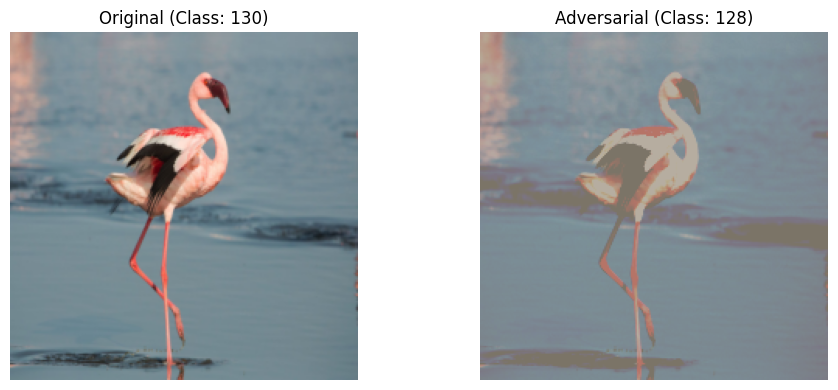

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

# Load pretrained model
model = models.resnet50(pretrained=True)
model.eval()

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
url = "https://cdn.britannica.com/88/588-050-07CF1220/lesser-flamingo-phoeniconaias-minor-namibia.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)
input_tensor.requires_grad = True

# Define target class (Flamingo)
true_class = 130

# Forward pass
output = model(input_tensor)
init_pred = output.max(1, keepdim=True)[1]

# Loss for correct class
loss = torch.nn.CrossEntropyLoss()(output, torch.tensor([true_class]))
model.zero_grad()
loss.backward()

# FGSM attack
epsilon = 0.01
perturbed_data = input_tensor + epsilon * input_tensor.grad.sign()
perturbed_data = torch.clamp(perturbed_data, 0, 1)

# Forward pass again
output_adv = model(perturbed_data)
final_pred = output_adv.max(1, keepdim=True)[1]

# Helper to denormalize for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor * std + mean

# Convert tensors to numpy images
orig = denormalize(input_tensor[0].detach()).permute(1, 2, 0).numpy()
adv = denormalize(perturbed_data[0].detach()).permute(1, 2, 0).numpy()

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.clip(orig, 0, 1))
plt.title(f"Original (Class: {init_pred.item()})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.clip(adv, 0, 1))
plt.title(f"Adversarial (Class: {final_pred.item()})")
plt.axis('off')

plt.tight_layout()
plt.show()


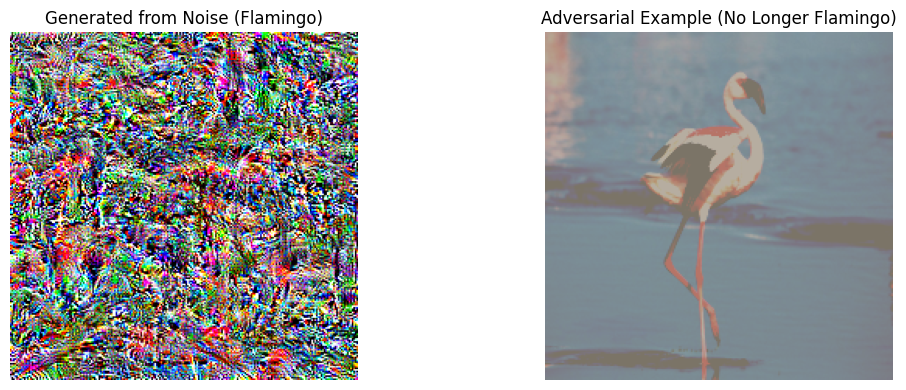

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(generated_img)
plt.title("Generated from Noise (Flamingo)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(adv)
plt.title("Adversarial Example (No Longer Flamingo)")
plt.axis('off')

plt.tight_layout()
plt.show()
